# Encoder练习
## 1. 构建训练数据

In [137]:
import torch 
import numpy
import torch.nn as nn
import torch.nn.functional as F

batch_size = 2
max_num_src_words = 8 # 原序列单词总数为8
max_num_target_words = 8

# define the max seq length
max_src_seq_len = 5
max_target_seq_len = 5

# src_len = torch.randint(low = 2, high = 5, size = (batch_size, ))
# target_len = torch.randint(low = 2, high = 5, size = (batch_size, ))
src_len = torch.Tensor([2, 4]).to(torch.int32)
target_len = torch.Tensor([4, 3]).to(torch.int32)

print("source lenth: ", src_len)
print("batch length: ", target_len)

src_seq = [torch.randint(low = 1, high = max_num_src_words, size = (L, )) for L in src_len]# 索引构成的句子
target_seq = [torch.randint(low = 1, high = max_num_src_words, size = (L, )) for L in target_len]# 索引构成的句子

# 因为句子长度不一样，在输入网络的时候需要保证句子长度一样，所以我们需要有一个padding的操作
src_seq = [F.pad(torch.randint(low = 1, high = max_num_src_words, size = (L, )), (0, max_src_seq_len - L)).unsqueeze(0) for L in src_len]
target_seq = [F.pad(torch.randint(low = 1, high = max_num_src_words, size = (L, )), (0, max_target_seq_len - L)).unsqueeze(0) for L in target_len]

# torch cat
src_seq = torch.cat(src_seq)
target_seq = torch.cat(target_seq)

print(src_seq)      # 原序列的单词索引
print(target_seq)   # 目标序列的单词索引

source lenth:  tensor([2, 4], dtype=torch.int32)
batch length:  tensor([4, 3], dtype=torch.int32)
tensor([[2, 6, 0, 0, 0],
        [6, 1, 6, 7, 0]])
tensor([[7, 4, 7, 5, 0],
        [1, 4, 1, 0, 0]])


## 2. 构造embedding

In [138]:
# 我们可以通过torch.nn.Embedding 来获取索引表
model_dim = 8 # 模型的特征大小

src_emb_table = nn.Embedding(max_num_src_words + 1, model_dim)
target_emb_table = nn.Embedding(max_num_target_words + 1, model_dim)

# 生成embedidng表格以后，就可以通过索引来或许table的值获取到的embedding的table
# 这里调用的是embedding的forward方法，这样我们就可以获取输入和输出的embedding了
src_emb = src_emb_table(src_seq)

## 3. 构造position embedding

$$ PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}) $$
$$ PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}) $$

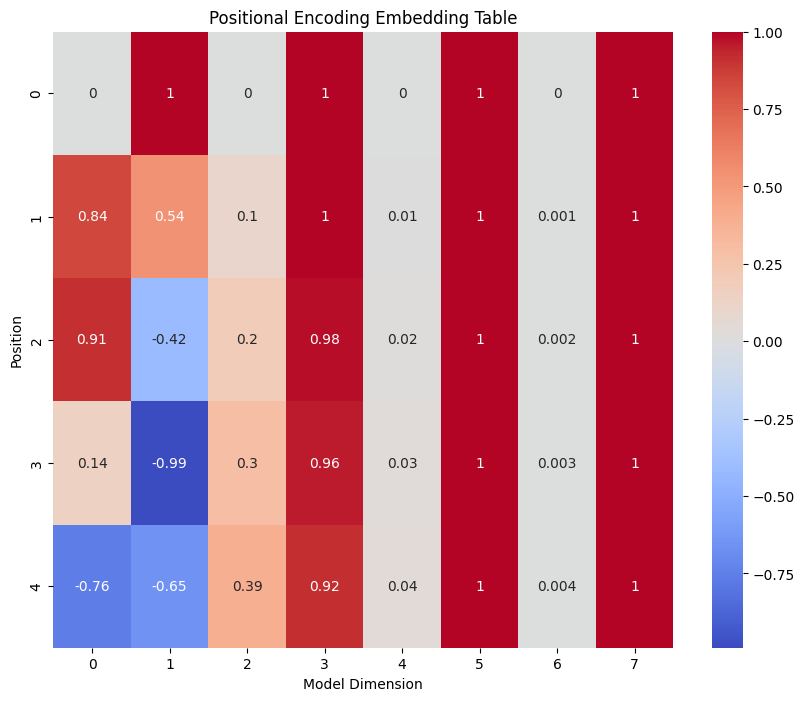

In [139]:
import seaborn as sns

max_position_len = 5 # 训练编码的最大长度

pos_mat = torch.arange(max_position_len).reshape((-1, 1))
i_mat = torch.arange(0, model_dim, 2).reshape((1, -1)) / model_dim
i_mat = torch.pow(1e4, i_mat)

pe_embedding_table = torch.zeros((max_position_len, model_dim))
pe_embedding_table[:, 0::2] = torch.sin(pos_mat / i_mat)
pe_embedding_table[:, 1::2] = torch.cos(pos_mat / i_mat)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pe_embedding_table.numpy(), annot=True, cmap='coolwarm')
plt.title('Positional Encoding Embedding Table')
plt.xlabel('Model Dimension')
plt.ylabel('Position')
plt.show()

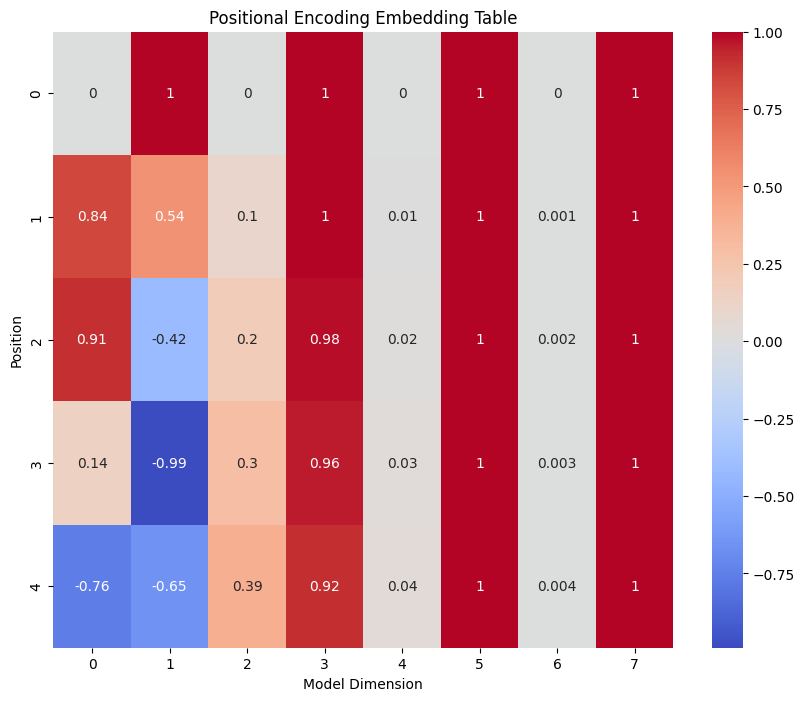

In [140]:
pe_embedding = nn.Embedding(max_position_len, model_dim)
pe_embedding.weight = nn.Parameter(pe_embedding_table, requires_grad = False)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(pe_embedding.weight.numpy(), annot=True, cmap='coolwarm')
plt.title('Positional Encoding Embedding Table')
plt.xlabel('Model Dimension')
plt.ylabel('Position')
plt.show()

In [141]:
# 这样就可以直接使用pe embedding作为函数了
src_pe_embedding = pe_embedding(torch.tensor([0, 1]))

然后基于embedding 我们可以得到Q,K,V。通过softmax得到attention score，然后通过attention score和V得到attention结果。我们希望soft max出来以后的变化方差不要太大，雅可比矩阵的导数不能变成0。

$$ Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V $$

In [142]:
# 构造encoder的self attention mask，我们希望被mask的值在softmax里面是负无穷的

valid_encoder_pos = [F.pad(torch.ones(L), (0, max(src_len) - L)).unsqueeze(0) for L in src_len]
valid_encoder_pos = torch.concat(valid_encoder_pos).unsqueeze(2)
print(valid_encoder_pos.shape)

valid_encoder_pos_mat = valid_encoder_pos @ valid_encoder_pos.transpose(1, 2)
# 里面的1表示有关联性
print("valid:\r\n", valid_encoder_pos_mat)

invalid_encoder_pos_matrix = 1 - valid_encoder_pos_mat
print("invalid:\r\n", invalid_encoder_pos_matrix)

# 注意encoder没有什么三角矩阵，但是decoder有，因为encoder没有什么因果性

torch.Size([2, 4, 1])
valid:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
invalid:
 tensor([[[0., 0., 1., 1.],
         [0., 0., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])


## 附录: softmax中scale的必要性探讨

In [143]:
# softmax 演示
alpha1 = 0.1
alpha2 = 10
score = torch.randn(5)
prob1 = F.softmax(score * alpha1, dim = -1)
print(prob1) # prob越大表示的是两个单词的关联性就越大
prob2 = F.softmax(score * alpha2, dim = -1)
print(prob2)
# 所以说这里的score缩放并不是一个线性的

def softmax_func(score):
    return F.softmax(score, dim = -1)

jaco_mat1 = torch.autograd.functional.jacobian(softmax_func, score * alpha1)
jaco_mat2 = torch.autograd.functional.jacobian(softmax_func, score * alpha2)

print(jaco_mat1)
print(jaco_mat2)
# 如果导数都变成0的话那么训练就会变得更缓慢

tensor([0.1931, 0.1906, 0.1606, 0.2331, 0.2227])
tensor([6.4887e-09, 1.7622e-09, 6.7171e-17, 9.8967e-01, 1.0328e-02])
tensor([[ 0.1558, -0.0368, -0.0310, -0.0450, -0.0430],
        [-0.0368,  0.1542, -0.0306, -0.0444, -0.0424],
        [-0.0310, -0.0306,  0.1348, -0.0374, -0.0358],
        [-0.0450, -0.0444, -0.0374,  0.1788, -0.0519],
        [-0.0430, -0.0424, -0.0358, -0.0519,  0.1731]])
tensor([[ 6.4887e-09, -1.1435e-17, -4.3585e-25, -6.4217e-09, -6.7018e-11],
        [-1.1435e-17,  1.7622e-09, -1.1837e-25, -1.7440e-09, -1.8201e-11],
        [-4.3585e-25, -1.1837e-25,  6.7171e-17, -6.6477e-17, -6.9376e-19],
        [-6.4217e-09, -1.7440e-09, -6.6477e-17,  1.0222e-02, -1.0222e-02],
        [-6.7018e-11, -1.8201e-11, -6.9376e-19, -1.0222e-02,  1.0222e-02]])


# Decoder

![](./../image/Decoder.png)

把encoder的输出作为memory，把这个当成key和value，然后根据这个key算出一个score，通过softmax得到一个权重，这个表征可以得到当前序列和目标序列的关系。

In [ ]:
# 构造intra-attention的mask
# valid_decoder_pos = valid_encoder_pos.clone().detach()
valid_decoder_pos = [F.pad(torch.ones(L), (0, max(target_len) - L)).unsqueeze(0) for L in target_len]
valid_decoder_pos = torch.concat(valid_decoder_pos).unsqueeze(2)

valid_cross_pos_mat = valid_decoder_pos @ valid_encoder_pos.transpose(1, 2)
invalid_cross_pos_mat = 1 - valid_cross_pos_mat

print(valid_encoder_pos)
print(valid_decoder_pos)
print(valid_cross_pos_mat)

tensor([[[1.],
         [1.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.]]])
tensor([[[1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         [0.]]])
tensor([[[1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 0., 0.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [0., 0., 0., 0.]]])


## Decoder Self-Attention Mask

图中的模型是一个自回归的模型，也就是说在预测第i个词的时候，只能看到前面的词，不能看到后面的词。所以我们需要一个mask来控制这个。

In [148]:
torch.tril(torch.ones((5,5))) # for triangle low, triangle up triu()

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [174]:
# for triangle low
valid_decoder_tri_mat = [
    F.pad(torch.tril(torch.ones(L, L)), (0, max(target_len)-L, 0, max(target_len)-L)).unsqueeze(0)
    for L in target_len
]

# concat the tensor
valid_decoder_tri_mat = torch.concat(valid_decoder_tri_mat)
invalid_decoder_tri_mat = 1 - valid_decoder_tri_mat

# print(invalid_decoder_tri_mat.shape)
# print(valid_decoder_tri_mat)

# test
score = torch.randn(batch_size, max(target_len), max(target_len))
masked_score = score.masked_fill(invalid_decoder_tri_mat == 1, -1e9)
prob = F.softmax(masked_score, -1)
print(target_len)
print(prob)

torch.Size([2, 4, 4])
tensor([4, 3], dtype=torch.int32)
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2750, 0.7250, 0.0000, 0.0000],
         [0.4805, 0.1682, 0.3513, 0.0000],
         [0.2149, 0.1552, 0.4257, 0.2041]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5849, 0.4151, 0.0000, 0.0000],
         [0.5134, 0.1585, 0.3281, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]]])


In [ ]:
# 构建self-attention
def scaled_dot_product_attention(Q, K, V, atten_mask):
    Q @ K.transpose(-1, -2)/torch.sqrt(model_dim)
    masked_score = score.masked_fill(atten_mask, -1e9)
    prob = F.softmax(masked_score, -1)
    context = prob @ V
    return context
